In [1]:
!pip install flask
!pip install pyserial
!pip install opencv-python
!pip install nbimporter
!pip install torch torchaudio torchvision
!jupyter nbconvert --to script text_processing.ipynb
!jupyter nbconvert --to script camera_operation.ipynb
!jupyter nbconvert --to script braille_translate.ipynb

[NbConvertApp] Converting notebook text_processing.ipynb to script
[NbConvertApp] Writing 5212 bytes to text_processing.py
[NbConvertApp] Converting notebook camera_operation.ipynb to script
[NbConvertApp] Writing 675 bytes to camera_operation.py
[NbConvertApp] Converting notebook braille_translate.ipynb to script
[NbConvertApp] Writing 8351 bytes to braille_translate.py


===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
 * Serving Flask app '__main__'
 * Debug mode: off
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.31:5000
Press CTRL+C to quit


===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.
===============  Received from Arduino ->  Next   ===============
[Warning] 리스트가 비어있습니다.


127.0.0.1 - - [25/Nov/2024 05:48:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /video?rand=0.9249646904269824 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /video?rand=0.5353938558810045 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /video?rand=0.4070543115693317 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /video?rand=0.19144675891211715 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /video?rand=0.9243313919701439 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /video?rand=0.769955646584791 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /video?rand=0.04291226122487002 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /video?rand=0.9341432008731783 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /video?rand=0.6639405843456976 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:48:49] "GET /arduino_received_mes

===============  Received from Arduino ->  Take Picture   ===============
< 1 - 이미지 촬영 >
1-1 이미지 촬영 진행 중입니다.
1-2 이미지 촬영이 완료되었습니다.
이미지 경로 : C:\Users\peter\capstone\camera\20241125-054938.jpg

< 2 - 텍스트 인식 >
2-1 이미지 내 텍스트 인식을 진행 중입니다.


127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /video?rand=0.38580852985545167 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /video?rand=0.02846341718776091 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /video?rand=0.671953652767433 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /video?rand=0.13181227955352814 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /video?rand=0.36687503024694434 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /video?rand=0.46689868524007205 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /video?rand=0.6105421437555516 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /video?rand=0.8862094921424035 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:49:39] "GET /video?ra

2-2 이미지 내 텍스트 인식을 완료했습니다.


127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /video?rand=0.8010678023528592 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /video?rand=0.7004723992101114 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /video?rand=0.16890291380315547 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /video?rand=0.670811438854914 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /video?rand=0.9885128128955241 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /video?rand=0.7920829098718767 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /video?rand=0.09633209300976309 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:05] "GET /video?rand=0.309748126730

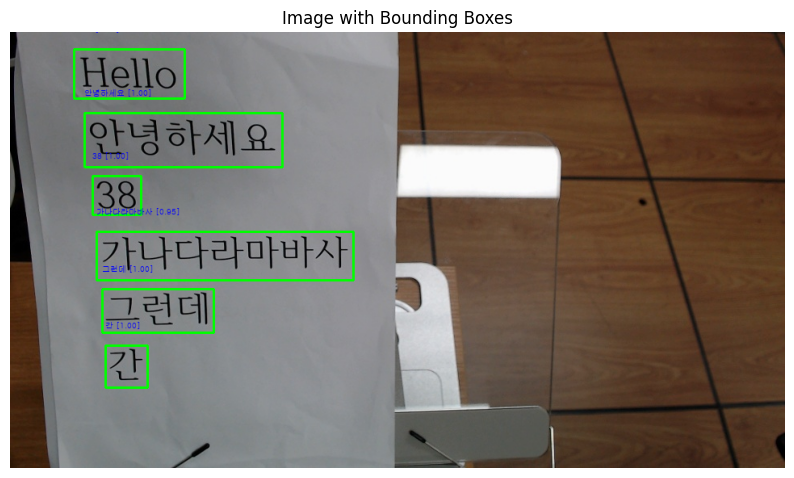

127.0.0.1 - - [25/Nov/2024 05:50:06] "GET /video?rand=0.9314321888153265 HTTP/1.1" 200 -


2-3 이미지 내 텍스트 라벨링 및 저장을 완료했습니다.
2-4 텍스트 철자 및 문법 교정을 진행 중입니다. 
한글은 아직 정의되지 않았습니다.


127.0.0.1 - - [25/Nov/2024 05:50:06] "GET /video?rand=0.5653713465797376 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.05389206997207596 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.33510038663847985 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.042494335623315393 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.27737749748452645 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.10781912061964394 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.31975973270134816 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.744939

한글은 아직 정의되지 않았습니다.
한글은 아직 정의되지 않았습니다.
한글은 아직 정의되지 않았습니다.
2-5 철자 및 문법 교정을 완료했습니다.
인식된 텍스트 >>>  ['Hello', '안녕하세요', '38', '가나다라마바사', '그런데', '간']
< 3 - 텍스트 점자로 변환 >
텍스트를 점자로 변환 중입니다...
점자 변환이 완료됐습니다.
점자 텍스트 >>>  ['3603421270705226', '4322114724035435', '371142', '4511210243120470', '1054', '4522']


127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.6952836953896111 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.2767942294334651 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.04510915124022796 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.584534388478605 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.6922009210613078 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:07] "GET /video?rand=0.48655204107968486 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:08] "GET /video?rand=0.5918152752490939 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:08] "GET /video?rand=0.410833896202

===============  Received from Arduino ->  Previous   ===============
리스트의 시작점입니다.


127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /video?rand=0.9693155206083064 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /video?rand=0.3603400175805127 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /video?rand=0.6151967315962279 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /video?rand=0.6591457622108721 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /video?rand=0.7589691837994899 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /labelled_image HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /video?rand=0.5850231643747572 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:14] "GET /video?rand=0.906600922158834 HTTP/1.1" 20

===============  Received from Arduino ->  Next   ===============
단어: Hello
점자: 3603421270705226


127.0.0.1 - - [25/Nov/2024 05:50:17] "GET /video?rand=0.3947322273727383 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:17] "GET /video?rand=0.14338648700864098 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:17] "GET /video?rand=0.5082635598455352 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:17] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:17] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:17] "GET /video?rand=0.000250536354184705 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:17] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:17] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:17] "GET /video?rand=0.8163018612914172 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:18] "GET /static/braille_4.png HTTP/1.1" 304 -
127.0.0.1 - - [25/Nov/2024 05:50:18] "GET /static/braille_0.png HTTP/1.1" 304 -
127.0.0.1 - - [25/Nov/2024 05:50:18] "GET /static/braille_5.png HTTP/1.1" 304 -
127.

===============  Received from Arduino ->  Previous   ===============
리스트의 시작점입니다.


127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /video?rand=0.2748810405120934 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /video?rand=0.8371482222809354 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /video?rand=0.10768515407252144 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /video?rand=0.929663792310842 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /video?rand=0.551305232244194 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /video?rand=0.8081352330007663 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /video?rand=0.8605669287746398 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:45] "GET /video?rand=0.25269476423180

===============  Received from Arduino ->  Next   ===============
단어: 안녕하세요
점자: 4322114724035435


127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /video?rand=0.7424348494812727 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /video?rand=0.5910886221639227 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /video?rand=0.006034870068478915 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /video?rand=0.28774093065884165 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /video?rand=0.7935081138305045 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /video?rand=0.6164932396950173 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /video?rand=0.04887191692828319 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /video?rand=0.8285686100371425 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:50:48] "GET /current_

===============  Received from Arduino ->  Next   ===============
단어: 38
점자: 371142


127.0.0.1 - - [25/Nov/2024 05:51:26] "GET /video?rand=0.18091503586263658 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:26] "GET /video?rand=0.19132875165781593 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:27] "GET /video?rand=0.8740222161095352 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:27] "GET /video?rand=0.2648745386607523 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:27] "GET /video?rand=0.02146966432063202 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:27] "GET /video?rand=0.7340401398759495 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:27] "GET /video?rand=0.6736332266125482 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:27] "GET /video?rand=0.0862084634299991 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:27] "GET /video?rand=0.5439876546741078 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:27] "GET /video?rand=0.43425690497723957 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:27] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/

===============  Received from Arduino ->  Next   ===============
단어: 가나다라마바사
점자: 4511210243120470


127.0.0.1 - - [25/Nov/2024 05:51:32] "GET /video?rand=0.6373850924581779 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /video?rand=0.7545669076429484 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /video?rand=0.7306291875617186 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /video?rand=0.10069804075224686 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /video?rand=0.2607476562512958 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /video?rand=0.013633530809458172 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /video?rand=0.4497604605831482 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /video?rand=0.2446036705525534 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /video?rand=0.20397025046005157 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:33]

===============  Received from Arduino ->  Next   ===============
단어: 그런데
점자: 1054


127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /video?rand=0.1857092457924816 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /video?rand=0.7514280742429482 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /video?rand=0.5862595409896447 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /video?rand=0.9681983746477247 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /video?rand=0.8494865562406637 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /video?rand=0.16121912371014946 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:36] "GET /video?rand=0.848828811895112 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:37] "GET /video?rand=0.5490402563099

===============  Received from Arduino ->  Next   ===============
단어: 간
점자: 4522


127.0.0.1 - - [25/Nov/2024 05:51:41] "GET /video?rand=0.8884903496366829 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:41] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:41] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:41] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:41] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:41] "GET /video?rand=0.408004061248036 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:41] "GET /video?rand=0.5635833867157445 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:42] "GET /video?rand=0.08277272294276061 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:42] "GET /video?rand=0.4207672992501055 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:42] "GET /video?rand=0.9496284190628774 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:42] "GET /video?rand=0.6670516964187867 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:42] "GET /video?rand=0.6188738084011

===============  Received from Arduino ->  Next   ===============
리스트의 끝점입니다.


127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /video?rand=0.7932955608387127 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /video?rand=0.08196453789349589 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /video?rand=0.4567591748210489 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /video?rand=0.5602459830588227 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /video?rand=0.08605872724343078 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:45] "GET /video?rand=0.09867030389716325 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /video?rand=0.6089704728819805 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /video?rand=0.5247993492

===============  Received from Arduino ->  Next   ===============
리스트의 끝점입니다.


127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /video?rand=0.8657446869572369 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /video?rand=0.47392060683127624 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /video?rand=0.3589394088204214 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /video?rand=0.4962918002807186 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /video?rand=0.7059902624830274 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /arduino_received_message HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /send_to_arduino HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /video?rand=0.09309981594966965 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /current_status HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /current_braille HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:46] "GET /video?rand=0.7413323068340181 HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2024 05:51:47] "GET /video?rand=0.66329086007

===============  Received from Arduino ->     ===============


In [2]:
from flask import Flask, render_template, Response, request, jsonify
import serial
import time
import os
import cv2
import threading
import io
from PIL import Image
from camera_operation import taking_picture
from text_processing import text_correction, text_detection
from braille_translate import text_to_braille

app = Flask(__name__)

# 연결할 시리얼 포트와 baudrate 설정
ser = serial.Serial('COM7', 9600)

# 변수 초기화
camera = cv2.VideoCapture(1)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1080) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
recognized_texts_global = []  # 인식된 텍스트 리스트
current_text_index = -1  # 리스트 위치 변수
braille_texts = []
labelled_img_path = None
word = ""
last_arduino_message = ""  # Arduino로부터 받은 마지막 메시지를 저장하는 변수
current_status_message = "촬영 버튼을 누르기 전 책을 화면과 같이 왼쪽 페이지와 오른쪽 페이지를 구분할 수 있도록 배치하십시오."

def read_from_port(ser):
    global recognized_texts_global, current_text_index, braille_texts, labelled_img_path, word, last_arduino_message, current_status_message
    
    while True:
        reading = ser.readline().decode().strip()
        current_status_message = ""
        
        print("===============  Received from Arduino -> ", reading, "  ===============")
        if reading == "Take Picture":
            # 메시지 업데이트
            last_arduino_message = "촬영 버튼"
            
            # 1 - 이미지 촬영
            print("< 1 - 이미지 촬영 >")
            img_path = taking_picture(camera)

            # 널값인지 검사
            if img_path is None:
                current_status_message = "이미지 촬영에 실패했습니다. 카메라를 확인하시고 다시 촬영해주세요."
                continue
            else:
                current_status_message = "이미지 촬영이 완료됐습니다. 텍스트 인식을 진행합니다."
            
            # 2 - 텍스트 인식
            print("< 2 - 텍스트 인식 >")
            recognized_texts, labelled_img_path = text_detection(img_path)

            # 인식된 텍스트 처리
            words_list = [word for text in recognized_texts for word in text.split()]
            try:
                corrected_texts = text_correction(words_list)
            except ValueError as e:
                print(f"예외 발생: {e}")
                continue
            
            filtered_texts = [text for text in corrected_texts if text.strip()]
            print("인식된 텍스트 >>> ", filtered_texts)
            recognized_texts_global = filtered_texts  # 새로운 텍스트로 업데이트
            current_text_index = -1  # 새로운 텍스트 리스트로 업데이트되면 인덱스 초기화
            
            # 3 - 텍스트를 점자로 변환하여 저장
            print("< 3 - 텍스트 점자로 변환 >")
            braille_texts = text_to_braille(recognized_texts_global)
            print("점자 텍스트 >>> ", braille_texts)
            current_status_message = "점자 변환이 완료됐습니다. 다음 단어 출력 버튼과 이전 버튼 출력을 눌러 점자 확인이 가능합니다."
            
        elif reading == "Next":
            last_arduino_message = "다음 단어 출력 버튼"
            next_text()
            
        elif reading == "Previous":
            last_arduino_message = "이전 단어 출력 버튼"
            previous_text()

def next_text():
    global current_text_index, word, current_status_message, recognized_texts_global, braille_texts
    
    if len(recognized_texts_global) == 0:
        current_status_message = "리스트가 비어있습니다. 촬영부터 진행해주세요."
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index < len(recognized_texts_global) - 1:
        current_text_index += 1
        word = recognized_texts_global[current_text_index]
        send_text_to_arduino(word, braille_texts[current_text_index])
    else:
        current_status_message = "인식된 텍스트를 다 읽었습니다. 페이지를 넘겨 촬영을 진행해주세요."
        print("리스트의 끝점입니다.")

def previous_text():
    global current_text_index, word, current_status_message, recognized_texts_global, braille_texts
    
    if len(recognized_texts_global) == 0:
        current_status_message = "리스트가 비어있습니다. 촬영부터 진행해주세요."
        print("[Warning] 리스트가 비어있습니다.")
        
    elif current_text_index > 0:
        current_text_index -= 1
        word = recognized_texts_global[current_text_index]
        send_text_to_arduino(word, braille_texts[current_text_index])
        
    else:
        current_status_message = "첫 번째 텍스트이므로 그 이전 단어가 없습니다."
        print("리스트의 시작점입니다.")

def send_text_to_arduino(text, braille):
    print("단어:", text)
    print("점자:", braille)
    ser.write((braille + "\n").encode())

def generate_frames():
    while True:
        success, frame = camera.read()  # 카메라로부터 프레임 읽기
        if not success:
            break
        else:
            # 프레임 크기 가져오기
            height, width, _ = frame.shape

            # 중앙선 그리기
            center_x = width // 2
            cv2.line(frame, (center_x, 0), (center_x, height), (0, 255, 0), 2)

            # 텍스트 출력
            cv2.putText(frame, 'Left Page', (50, height // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.putText(frame, 'Right Page', (center_x + 270, height // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # JPEG 형식으로 인코딩
            ret, buffer = cv2.imencode('.jpg', frame)
            frame = buffer.tobytes()

            yield (b'--frame\r\n'
                   b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')

@app.route('/')
def index():
    return render_template('kdn_index.html', initial_status_message=current_status_message)

@app.route('/video')
def video():
    return Response(generate_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/labelled_image')
def labelled_image():
    img = cv2.imread(labelled_img_path)
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_io = io.BytesIO()
    img_pil.save(img_io, 'JPEG', quality=70)
    img_io.seek(0)
    return Response(img_io.getvalue(), mimetype='image/jpeg')

@app.route('/arduino_received_message')
def arduino_received_message():
    # Arduino로부터 받은 마지막 메시지를 반환합니다.
    return jsonify({"message": last_arduino_message})

@app.route('/send_to_arduino')
def send_to_arduino():
    # Arduino로 보낸 문자열 반환
    return jsonify({"message": word})

@app.route('/current_status')
def get_current_status():
    # 현재 진행 상황을 출력
    return jsonify({"message": current_status_message})

@app.route('/current_braille')
def current_braille():
    if current_text_index >= 0 and current_text_index < len(braille_texts):
        braille = braille_texts[current_text_index]
        braille_images = []
        
        for char in braille:
            img_src = f"/static/braille_{char}.png"  # 이미지 URL 생성
            braille_images.append(img_src)
        
        return jsonify({"braille_images": braille_images})
    else:
        return jsonify({"braille_images": []})

if __name__ == '__main__':
    thread = threading.Thread(target=read_from_port, args=(ser,))
    thread.start()
    app.run(debug=False, host='0.0.0.0', port=5000) 